**Задание**

1. Реализовать параллельную сортировку слиянием на CUDA:

● Разделите массив на блоки, каждый из которых будет обрабатываться
одним блоком потоков.

● Сортируйте блоки параллельно и сливайте их по парам.


В рамках выполнения заданий 1–3 требования задания 4 были реализованы не отдельным этапом, а непосредственно при разработке каждого алгоритма сортировки.

Для каждого алгоритма параллельной сортировки на GPU (CUDA) одновременно были реализованы соответствующие последовательные версии на CPU, что позволило проводить прямое сравнение производительности.

Измерение времени выполнения осуществлялось:

* для CPU-версий алгоритмов;

* для GPU-версий алгоритмов;

* на массивах различного размера:
10 000, 100 000 и 1 000 000 элементов.

Таким образом, при выполнении каждого из заданий 1–3:

* реализованы как параллельные алгоритмы сортировки на GPU, так и их последовательные аналоги на CPU;

* выполнены замеры времени выполнения для CPU и GPU;

Следовательно, задание 4 («Сравнение производительности») было полностью выполнено в составе заданий 1–3, без необходимости отдельной реализации, поскольку анализ времени выполнения и сравнение CPU/GPU являлись неотъемлемой частью каждого задания.

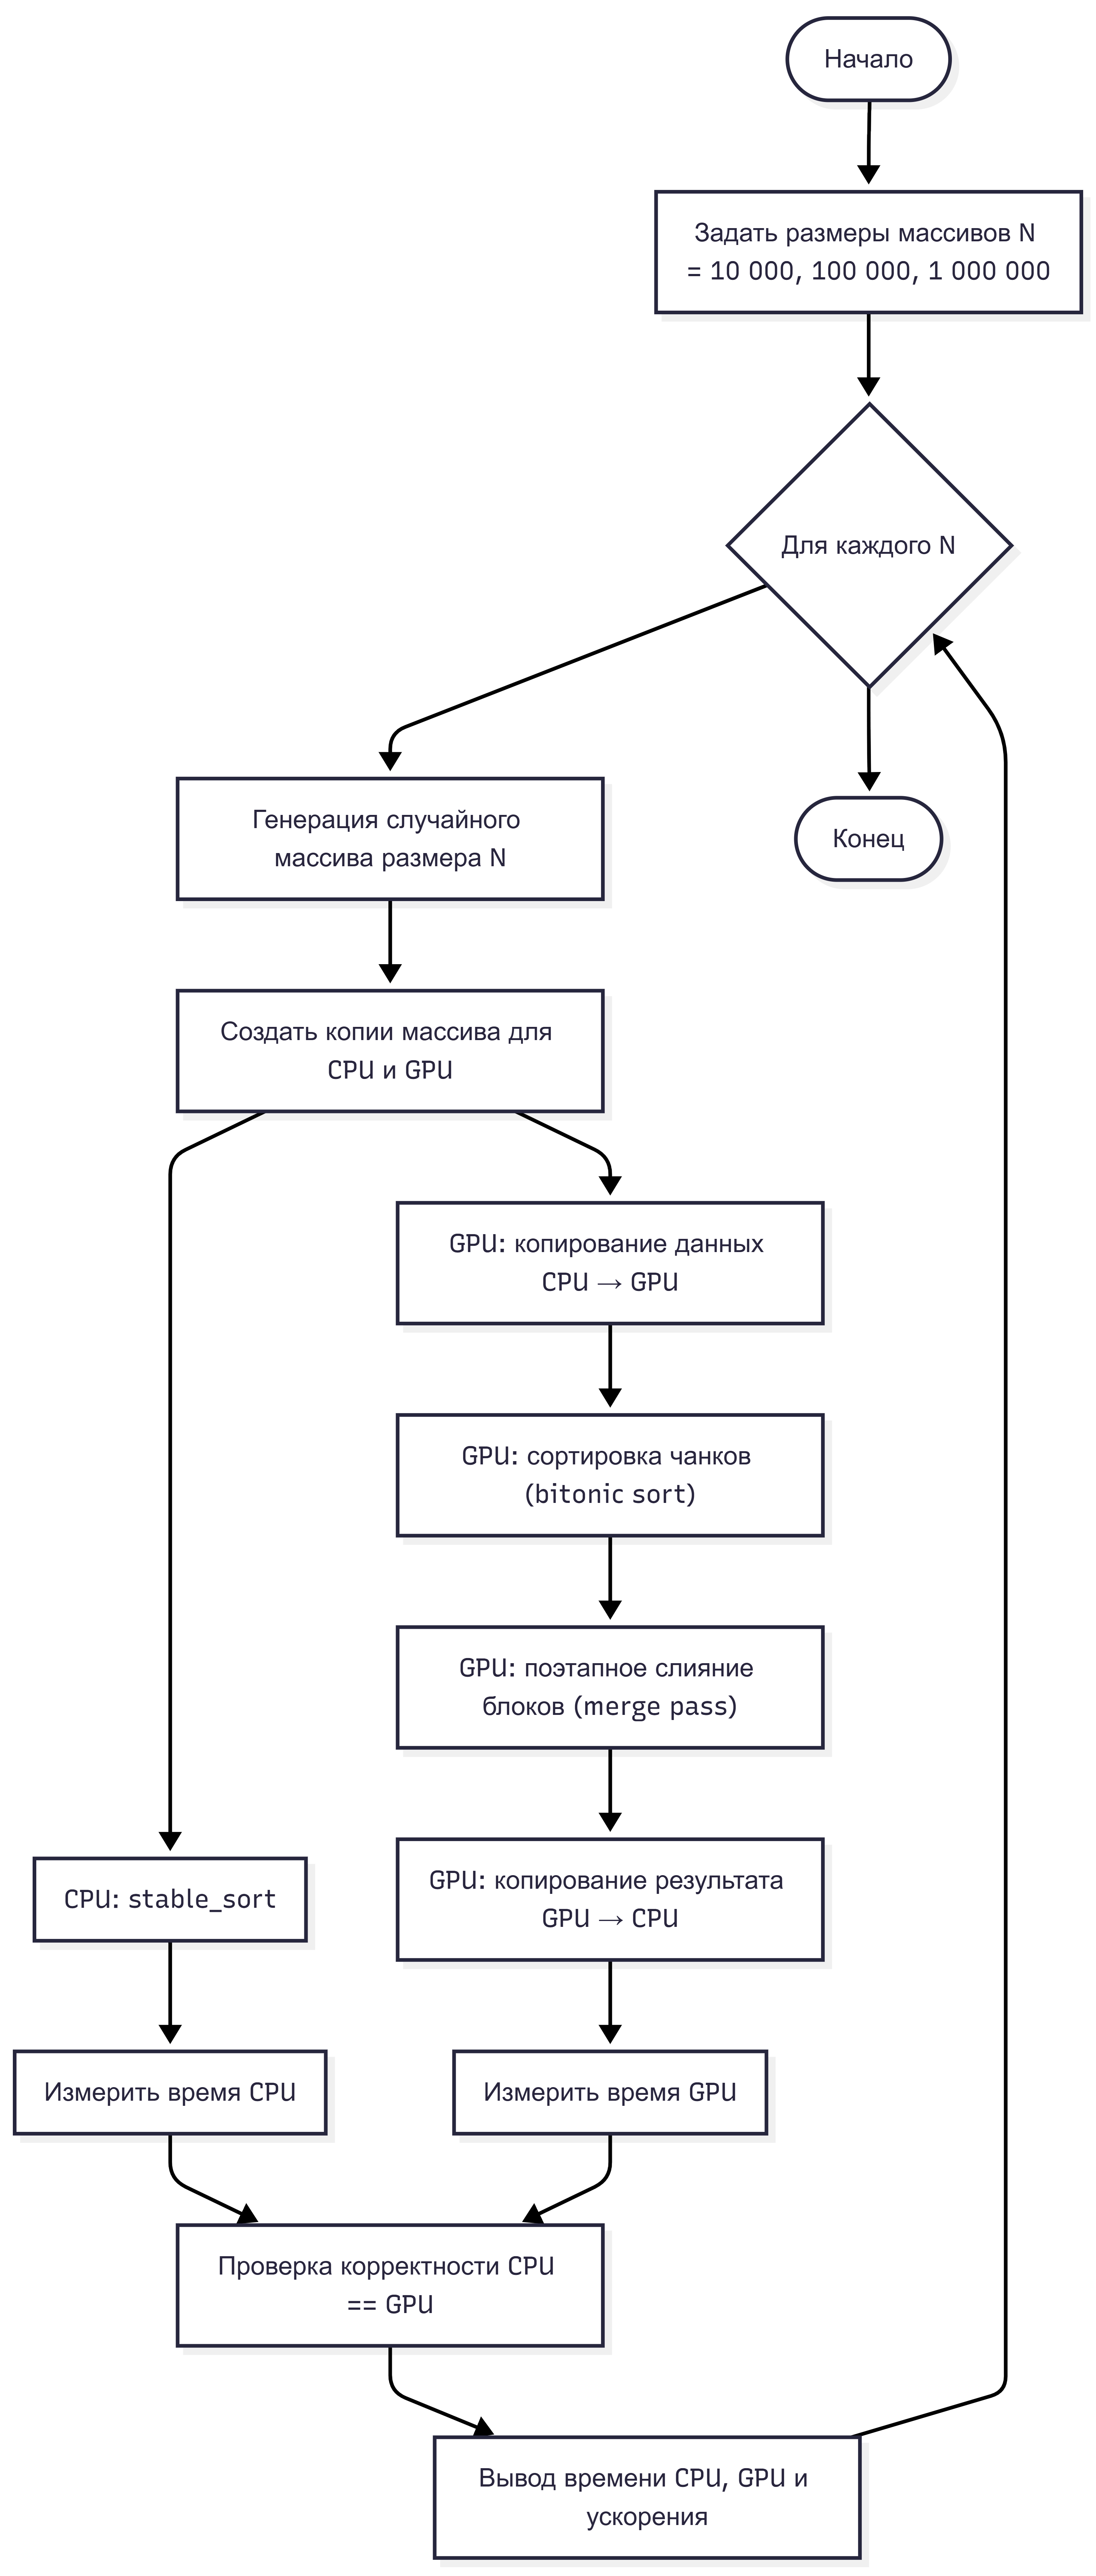

**Задание**

4. Сравнение производительности:

● Реализуйте последовательные версии этих алгоритмов на CPU.

● Измерьте время выполнения каждой сортировки на CPU и на GPU для
массивов разного размера (например, 10,000, 100,000 и 1,000,000
элементов).

● Сравните производительность и сделайте выводы.

In [ ]:
!nvidia-smi #это утилита NVIDIA, которая показывает состояние видеокарты.
!nvcc --version #это CUDA-компилятор

Thu Dec 25 04:36:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%%writefile 1main.cu
// Подключаем CUDA Runtime API (cudaMalloc, cudaMemcpy и т.д.)
#include <cuda_runtime.h>
// Подключаем определения для threadIdx, blockIdx и др.
#include <device_launch_parameters.h>

// Стандартные библиотеки C++
#include <algorithm>   // stable_sort
#include <chrono>      // измерение времени
#include <climits>     // INT_MAX
#include <iostream>    // cout
#include <random>      // генератор случайных чисел
#include <vector>      // std::vector

// Макрос для проверки ошибок CUDA-вызовов
// Если ошибка произошла — выводим сообщение и завершаем программу
#define CUDA_CHECK(call) do {                                \
    cudaError_t e = (call);                                  \
    if (e != cudaSuccess) {                                  \
        std::cerr << "CUDA error: "                           \
                  << cudaGetErrorString(e)                    \
                  << " at " << __FILE__ << ":" << __LINE__    \
                  << std::endl;                               \
        std::exit(1);                                        \
    }                                                        \
} while(0)

// Функция проверки: отсортирован ли массив по возрастанию (CPU)
static bool is_sorted_cpu(const std::vector<int>& a) {
    for (size_t i = 1; i < a.size(); ++i)
        if (a[i-1] > a[i]) return false;
    return true;
}

// 1) СОРТИРОВКА КУСКОВ НА GPU
// Размер одного блока данных, сортируемого одним CUDA-блоком
// Должен быть степенью двойки (для bitonic sort)
constexpr int CHUNK = 1024;

// CUDA-ядро: каждый блок сортирует свой участок массива
__global__ void chunk_sort_bitonic(const int* in, int* out, int n) {

    // Shared memory — быстрая память, общая для потоков одного блока
    __shared__ int s[CHUNK];

    // Начальный индекс текущего блока в глобальном массиве
    int base = (int)blockIdx.x * CHUNK;
    // Индекс потока внутри блока
    int tid  = (int)threadIdx.x;

    // Загружаем данные из глобальной памяти в shared memory
    // Если выходим за пределы массива — заполняем INT_MAX
    for (int i = tid; i < CHUNK; i += (int)blockDim.x) {
        int idx = base + i;
        s[i] = (idx < n) ? in[idx] : INT_MAX;
    }

    // Ждём, пока все потоки загрузят данные
    __syncthreads();

    // Реализация bitonic sort в shared memory
    for (int k = 2; k <= CHUNK; k <<= 1) {
        for (int j = k >> 1; j > 0; j >>= 1) {
            for (int i = tid; i < CHUNK; i += (int)blockDim.x) {

                // Индекс элемента для сравнения (bitonic network)
                int ixj = i ^ j;

                if (ixj > i) {
                    // Определяем направление сортировки
                    bool ascending = ((i & k) == 0);

                    int a = s[i];
                    int b = s[ixj];

                    // Меняем элементы местами при необходимости
                    if ((ascending && a > b) || (!ascending && a < b)) {
                        s[i] = b;
                        s[ixj] = a;
                    }
                }
            }
            // Синхронизация потоков перед следующим шагом
            __syncthreads();
        }
    }

    // Записываем отсортированный chunk обратно в глобальную память
    for (int i = tid; i < CHUNK; i += (int)blockDim.x) {
        int idx = base + i;
        if (idx < n) out[idx] = s[i];
    }
}

// 2) СЛИЯНИЕ ОТСОРТИРОВАННЫХ КУСКОВ (MERGE PASS)
// Функция merge-path: находит позицию элемента при слиянии двух массивов
__device__ int merge_path_search(const int* A, int aCount,
                                 const int* B, int bCount,
                                 int diag) {
    int lo = max(0, diag - bCount);
    int hi = min(diag, aCount);

    while (lo < hi) {
        int mid = (lo + hi) >> 1;
        int j = diag - mid;

        int A_left  = (mid > 0) ? A[mid - 1] : INT_MIN;
        int A_right = (mid < aCount) ? A[mid] : INT_MAX;
        int B_left  = (j > 0) ? B[j - 1] : INT_MIN;
        int B_right = (j < bCount) ? B[j] : INT_MAX;

        if (A_left > B_right) hi = mid;
        else if (B_left >= A_right) lo = mid + 1;
        else return mid;
    }
    return lo;
}

// CUDA-ядро: сливает два соседних отсортированных участка массива
__global__ void merge_pass(const int* in, int* out, int n, int width) {

    // Каждый блок отвечает за одну пару массивов
    int pair = (int)blockIdx.x;
    int left = pair * (2 * width);
    if (left >= n) return;

    int mid   = left + width;
    int right = min(left + 2 * width, n);

    int aCount = min(width, n - left);
    int bCount = max(0, right - mid);

    const int* A = in + left;
    const int* B = in + mid;

    int total = aCount + bCount;

    int tid = (int)threadIdx.x;
    int stride = (int)blockDim.x;

    // Каждый поток обрабатывает несколько элементов результата
    for (int diag = tid; diag < total; diag += stride) {
        int i = merge_path_search(A, aCount, B, bCount, diag);
        int j = diag - i;

        int aVal = (i < aCount) ? A[i] : INT_MAX;
        int bVal = (j < bCount) ? B[j] : INT_MAX;

        out[left + diag] = (aVal <= bVal) ? aVal : bVal;
    }
}

// ОБЁРТКА GPU MERGE SORT
void gpu_merge_sort(std::vector<int>& a, float& ms_total) {

    int n = (int)a.size();
    if (n == 0) { ms_total = 0; return; }

    int* d_in  = nullptr;
    int* d_tmp = nullptr;

    // Выделяем память на GPU
    CUDA_CHECK(cudaMalloc(&d_in,  n * sizeof(int)));
    CUDA_CHECK(cudaMalloc(&d_tmp, n * sizeof(int)));

    // Копируем данные с CPU на GPU
    CUDA_CHECK(cudaMemcpy(d_in, a.data(), n * sizeof(int),
                          cudaMemcpyHostToDevice));

    // CUDA события для замера времени GPU
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    // 1) Параллельная сортировка chunk'ов
    int numChunks = (n + CHUNK - 1) / CHUNK;
    chunk_sort_bitonic<<<numChunks, 256>>>(d_in, d_tmp, n);
    CUDA_CHECK(cudaGetLastError());

    // 2) Последовательные проходы слияния (width удваивается)
    int* src = d_tmp;
    int* dst = d_in;

    for (int width = CHUNK; width < n; width <<= 1) {
        int numPairs = (n + 2 * width - 1) / (2 * width);
        merge_pass<<<numPairs, 256>>>(src, dst, n, width);
        CUDA_CHECK(cudaGetLastError());
        std::swap(src, dst);
    }

    // Останавливаем таймер GPU
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    CUDA_CHECK(cudaEventElapsedTime(&ms_total, start, stop));

    // Копируем результат обратно на CPU
    CUDA_CHECK(cudaMemcpy(a.data(), src, n * sizeof(int),
                          cudaMemcpyDeviceToHost));

    // Освобождаем ресурсы
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
    CUDA_CHECK(cudaFree(d_in));
    CUDA_CHECK(cudaFree(d_tmp));
}
// MAIN
int main() {

    // Размеры массивов для тестирования
    std::vector<int> sizes = {10000, 100000, 1000000};

    // Генератор случайных чисел
    std::mt19937 rng(12345);
    std::uniform_int_distribution<int> dist(0, 1000000);

    for (int N : sizes) {

        // Генерируем входной массив
        std::vector<int> a(N);
        for (int i = 0; i < N; ++i)
            a[i] = dist(rng);

        // Копия для CPU-сортировки
        std::vector<int> ref = a;

        // CPU сортировка + замер времени
        auto t0 = std::chrono::high_resolution_clock::now();
        std::stable_sort(ref.begin(), ref.end());
        auto t1 = std::chrono::high_resolution_clock::now();
        double cpu_ms =
            std::chrono::duration<double, std::milli>(t1 - t0).count();

        // GPU сортировка
        float gpu_ms = 0.0f;
        gpu_merge_sort(a, gpu_ms);

        // Проверка корректности
        bool ok = (a == ref) && is_sorted_cpu(a);

        // Вывод результатов
        std::cout << "\nN = " << N << "\n";
        std::cout << "CPU stable_sort: " << cpu_ms << " ms\n";
        std::cout << "GPU MergeSort:   " << gpu_ms << " ms\n";
        std::cout << "Correct: " << (ok ? "YES" : "NO") << "\n";
        if (gpu_ms > 0)
            std::cout << "Speedup CPU/GPU: "
                      << (cpu_ms / gpu_ms) << "x\n";
    }

    return 0;
}

Writing 1main.cu


In [ ]:
!nvcc -O2 -arch=sm_75 1main.cu -o 1main #компиляция CUDA-программы
!./1main #запуск программы



N = 10000
CPU stable_sort: 0.907922 ms
GPU MergeSort:   0.604128 ms
Correct: YES
Speedup CPU/GPU: 1.50286x

N = 100000
CPU stable_sort: 8.01978 ms
GPU MergeSort:   4.50947 ms
Correct: YES
Speedup CPU/GPU: 1.77843x

N = 1000000
CPU stable_sort: 95.8275 ms
GPU MergeSort:   57.1595 ms
Correct: YES
Speedup CPU/GPU: 1.67649x


**Вывод:** Параллельная сортировка слиянием на CUDA была реализована по требованию: массив делился на блоки, блоки сортировались параллельно, затем выполнялось попарное слияние. Корректность результатов подтверждена (Correct: YES для всех N).

По времени выполнения GPU-версия оказалась быстрее CPU (stable_sort) на всех размерах массива:

N=10 000: ускорение 1.50× (0.91 ms → 0.60 ms)

N=100 000: ускорение 1.78× (8.02 ms → 4.51 ms)

N=1 000 000: ускорение 1.68× (95.83 ms → 57.16 ms)

Следовательно, использование GPU даёт стабильное ускорение ~1.5–1.8×, а наибольший эффект наблюдается на средних и больших объёмах данных.

**Задание**

2. Реализовать параллельную быструю сортировку на CUDA:

● Используйте параллельные потоки для деления массива по опорному
элементу.

● В каждом потоке выполняется быстрая сортировка на своей части
массива.

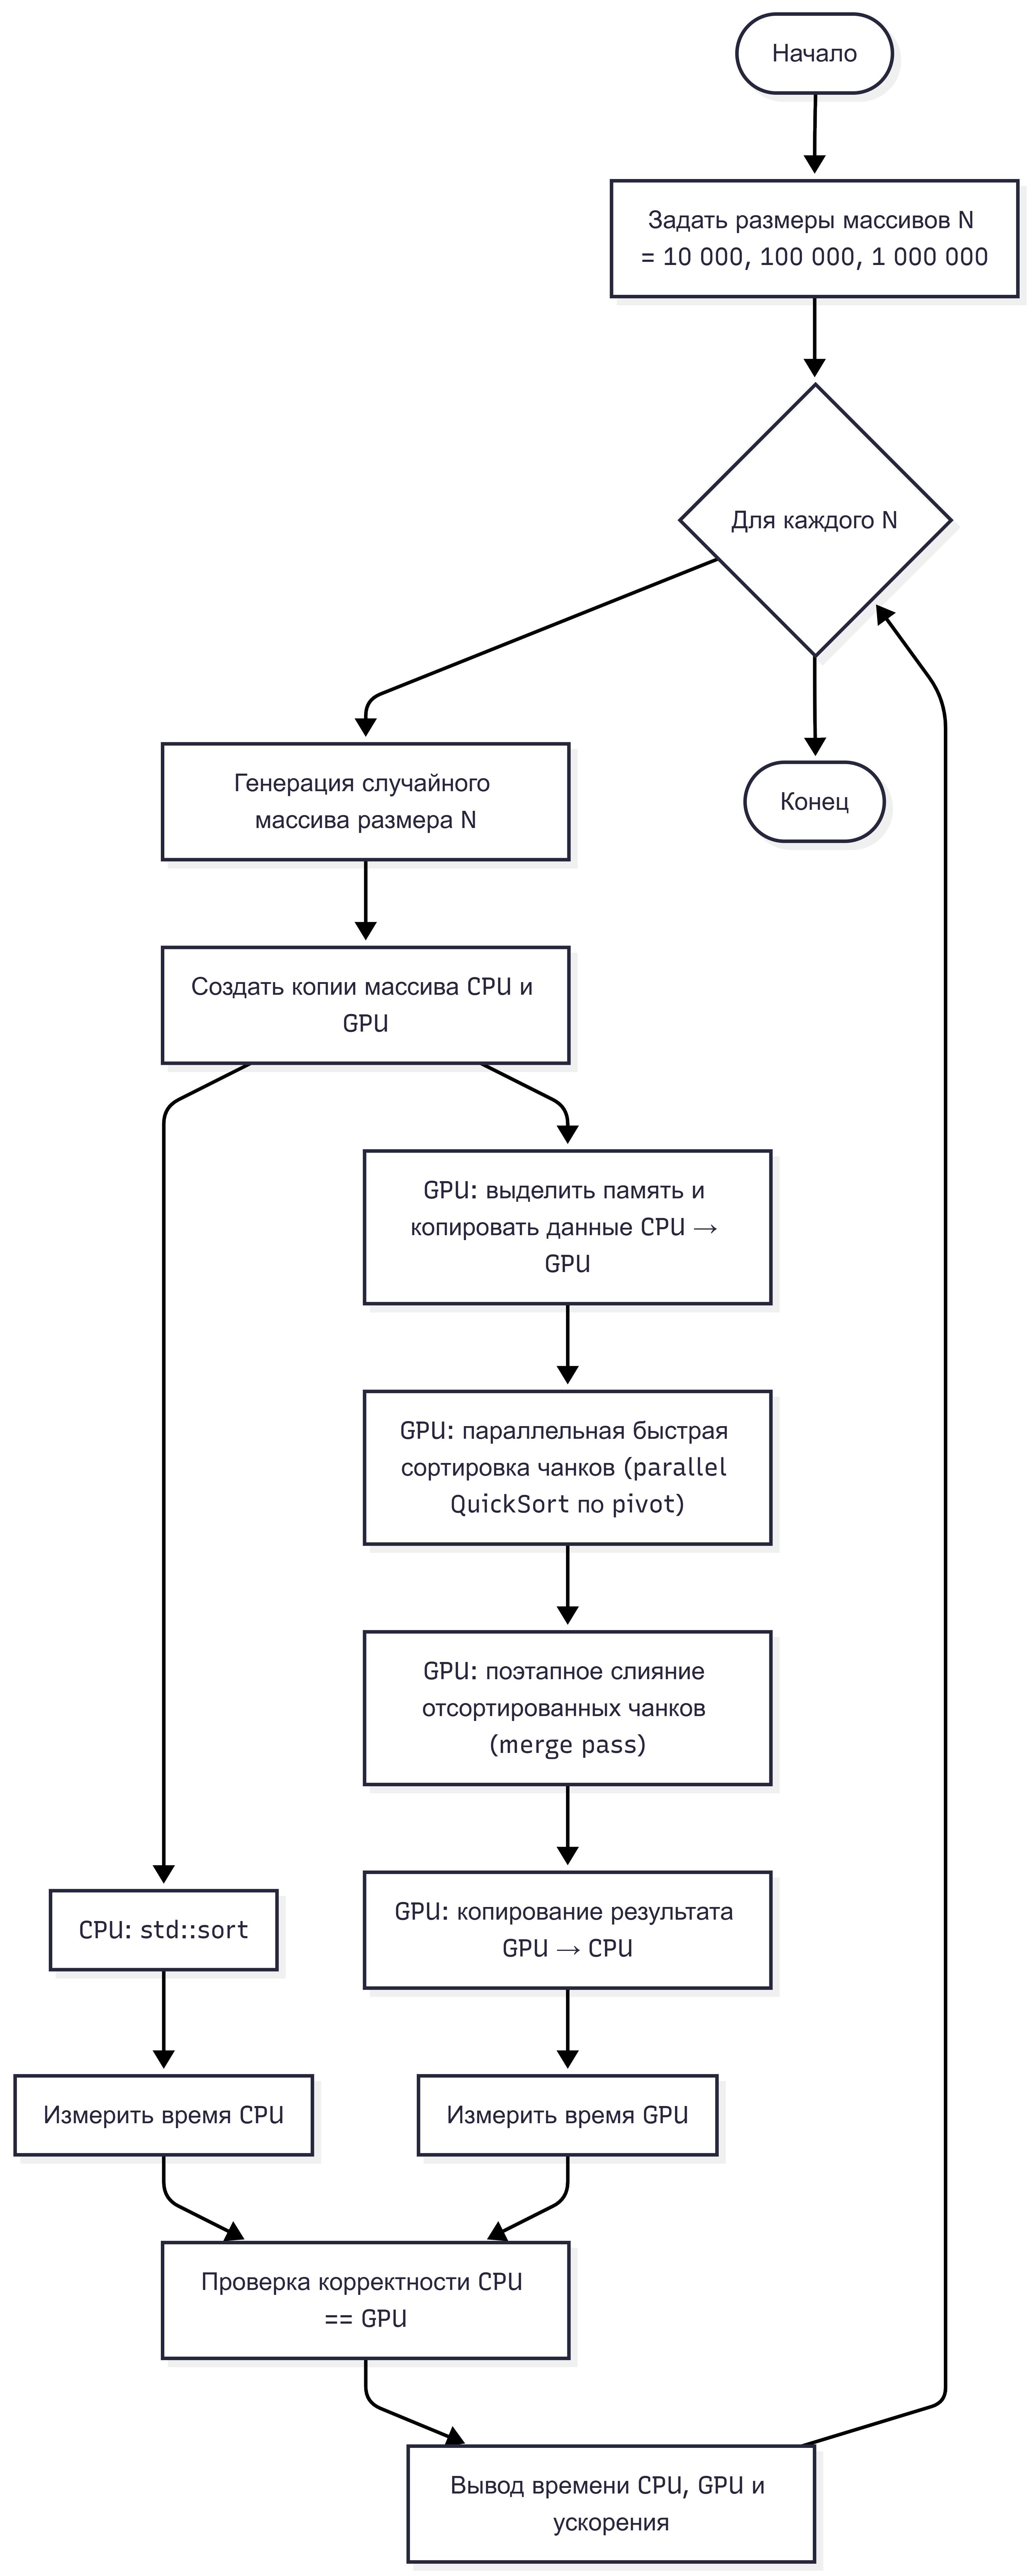

In [ ]:
%%writefile 2main.cu
// Основной CUDA Runtime API
#include <cuda_runtime.h>
// Доступ к threadIdx, blockIdx, blockDim
#include <device_launch_parameters.h>

// Стандартные библиотеки C++
#include <algorithm>   // std::sort
#include <chrono>      // измерение времени
#include <climits>     // INT_MAX, INT_MIN
#include <iostream>    // вывод в консоль
#include <random>      // генерация случайных чисел
#include <vector>      // std::vector

// Макрос для проверки ошибок CUDA
// Оборачивает каждый вызов CUDA и проверяет,
// не вернула ли функция ошибку
#define CUDA_CHECK(call) do {                                \
    cudaError_t e = (call);                                  \
    if (e != cudaSuccess) {                                  \
        std::cerr << "CUDA error: "                           \
                  << cudaGetErrorString(e)                    \
                  << " at " << __FILE__ << ":" << __LINE__    \
                  << std::endl;                               \
        std::exit(1);                                        \
    }                                                        \
} while(0)

// Проверка отсортированности массива (CPU)
static bool is_sorted_cpu(const std::vector<int>& a) {
    // Проверяем, что каждый следующий элемент >= предыдущего
    for (size_t i = 1; i < a.size(); ++i)
        if (a[i - 1] > a[i]) return false;
    return true;
}

// GPU MERGE PASS — используется для финального слияния chunk'ов
// Функция merge-path (работает на GPU):
// по диагональному индексу diag находит,
// сколько элементов взять из массива A
__device__ int merge_path_search(const int* A, int aCount,
                                 const int* B, int bCount,
                                 int diag) {

    // Диапазон бинарного поиска
    int lo = max(0, diag - bCount);
    int hi = min(diag, aCount);

    // Бинарный поиск границы слияния
    while (lo < hi) {
        int mid = (lo + hi) >> 1;
        int j = diag - mid;

        // Граничные значения
        int A_left  = (mid > 0) ? A[mid - 1] : INT_MIN;
        int A_right = (mid < aCount) ? A[mid] : INT_MAX;
        int B_left  = (j > 0) ? B[j - 1] : INT_MIN;
        int B_right = (j < bCount) ? B[j] : INT_MAX;

        if (A_left > B_right) hi = mid;
        else if (B_left >= A_right) lo = mid + 1;
        else return mid;
    }
    return lo;
}

// CUDA-ядро: слияние двух отсортированных участков
__global__ void merge_pass(const int* in, int* out, int n, int width) {

    // Каждый CUDA-блок обрабатывает одну пару подмассивов
    int pair = (int)blockIdx.x;
    int left = pair * (2 * width);
    if (left >= n) return;

    // Границы двух массивов
    int mid   = left + width;
    int right = min(left + 2 * width, n);

    int aCount = min(width, n - left);
    int bCount = max(0, right - mid);

    // Указатели на левый и правый массив
    const int* A = in + left;
    const int* B = in + mid;

    int total = aCount + bCount;

    // Индекс потока и шаг по диагонали
    int tid = (int)threadIdx.x;
    int stride = (int)blockDim.x;

    // Каждый поток вычисляет несколько элементов результата
    for (int diag = tid; diag < total; diag += stride) {

        // Находим позицию в A и B
        int i = merge_path_search(A, aCount, B, bCount, diag);
        int j = diag - i;

        // Берём минимальный из двух кандидатов
        int aVal = (i < aCount) ? A[i] : INT_MAX;
        int bVal = (j < bCount) ? B[j] : INT_MAX;

        out[left + diag] = (aVal <= bVal) ? aVal : bVal;
    }
}

// GPU QUICK SORT PER CHUNK
// Каждый CUDA-блок сортирует один chunk массива.
// Разделение по pivot выполняется параллельно потоками.
// После этого quicksort рекурсивно сортирует части.

constexpr int CHUNK = 1024;          // размер chunk'а
constexpr int INSERTION_CUTOFF = 32; // маленькие диапазоны -> insertion sort

// Insertion sort для маленьких диапазонов (GPU)
__device__ __forceinline__
void insertion_sort(int* a, int l, int r) {
    for (int i = l + 1; i <= r; ++i) {
        int key = a[i];
        int j = i - 1;
        while (j >= l && a[j] > key) {
            a[j + 1] = a[j];
            --j;
        }
        a[j + 1] = key;
    }
}

// CUDA-ядро: параллельный quicksort одного chunk'а
__global__ void chunk_quick_sort_parallel(const int* in, int* out, int n) {

    // Shared memory для chunk'а
    __shared__ int s[CHUNK];
    __shared__ int tmp[CHUNK];

    // Начальный индекс chunk'а
    int base = (int)blockIdx.x * CHUNK;
    int tid  = (int)threadIdx.x;

    // Загружаем данные из глобальной памяти в shared
    for (int i = tid; i < CHUNK; i += (int)blockDim.x) {
        int idx = base + i;
        s[i] = (idx < n) ? in[idx] : INT_MAX;
    }
    __syncthreads();

    // Итеративный quicksort (через стек)
    __shared__ int lstack[64]; // левая граница
    __shared__ int rstack[64]; // правая граница
    __shared__ int top;        // указатель стека

    // Инициализация стека (делает 1 поток)
    if (tid == 0) {
        top = 0;
        lstack[0] = 0;
        rstack[0] = CHUNK - 1;
    }
    __syncthreads();

    // Основной цикл quicksort
    while (true) {
        int l, r;

        // Один поток извлекает диапазон из стека
        if (tid == 0) {
            if (top < 0) {
                l = r = -1; // сигнал выхода
            } else {
                l = lstack[top];
                r = rstack[top];
                top--;
            }
        }

        // Рассылаем l и r всем потокам
        __shared__ int curL, curR;
        if (tid == 0) { curL = l; curR = r; }
        __syncthreads();

        l = curL; r = curR;
        if (l < 0) break;
        if (r - l + 1 <= 1) continue;

        // Маленький диапазон — insertion sort
        if (r - l + 1 <= INSERTION_CUTOFF) {
            if (tid == 0) insertion_sort(s, l, r);
            __syncthreads();
            continue;
        }

        // Выбор опорного элемента (pivot)
        int pivot = s[(l + r) >> 1];

        // Параллельное разбиение по pivot
        __shared__ int lessCount, equalCount, greaterCount;
        if (tid == 0) { lessCount = 0; equalCount = 0; greaterCount = 0; }
        __syncthreads();

        // Каждый поток обрабатывает часть элементов
        for (int i = l + tid; i <= r; i += (int)blockDim.x) {
            int v = s[i];
            if (v < pivot) {
                int pos = atomicAdd(&lessCount, 1);
                tmp[l + pos] = v;
            } else if (v > pivot) {
                int pos = atomicAdd(&greaterCount, 1);
                tmp[r - pos] = v;
            } else {
                int pos = atomicAdd(&equalCount, 1);
                tmp[l + pos] = v;
            }
        }
        __syncthreads();

        // Подсчёт размеров подмассивов
        __shared__ int Lc, Ec, Gc;
        if (tid == 0) { Lc = lessCount; Ec = equalCount; Gc = greaterCount; }
        __syncthreads();

        // Вторая фаза: корректная перестановка элементов
        __shared__ int wLess, wEq, wGt;
        if (tid == 0) { wLess = 0; wEq = 0; wGt = 0; }
        __syncthreads();

        for (int i = l + tid; i <= r; i += (int)blockDim.x) {
            int v = s[i];
            if (v < pivot) {
                int pos = atomicAdd(&wLess, 1);
                tmp[l + pos] = v;
            } else if (v == pivot) {
                int pos = atomicAdd(&wEq, 1);
                tmp[l + Lc + pos] = v;
            } else {
                int pos = atomicAdd(&wGt, 1);
                tmp[r - pos] = v;
            }
        }
        __syncthreads();

        // Копируем результат разбиения обратно
        for (int i = l + tid; i <= r; i += (int)blockDim.x) {
            s[i] = tmp[i];
        }
        __syncthreads();

        // Добавляем новые поддиапазоны в стек
        if (tid == 0) {
            int leftL = l;
            int leftR = l + Lc - 1;
            int rightL = l + Lc + Ec;
            int rightR = r;

            int leftSize  = leftR - leftL + 1;
            int rightSize = rightR - rightL + 1;

            if (leftSize > 1 && rightSize > 1) {
                if (leftSize < rightSize) {
                    top++; lstack[top] = rightL; rstack[top] = rightR;
                    top++; lstack[top] = leftL;  rstack[top] = leftR;
                } else {
                    top++; lstack[top] = leftL;  rstack[top] = leftR;
                    top++; lstack[top] = rightL; rstack[top] = rightR;
                }
            } else if (leftSize > 1) {
                top++; lstack[top] = leftL; rstack[top] = leftR;
            } else if (rightSize > 1) {
                top++; lstack[top] = rightL; rstack[top] = rightR;
            }
        }
        __syncthreads();
    }

    // Записываем отсортированный chunk в глобальную память
    for (int i = tid; i < CHUNK; i += (int)blockDim.x) {
        int idx = base + i;
        if (idx < n) out[idx] = s[i];
    }
}

// HOST: обёртка GPU quick sort + merge
void gpu_quick_sort(std::vector<int>& a, float& ms_total) {

    int n = (int)a.size();
    if (n == 0) { ms_total = 0; return; }

    int* d_in  = nullptr;
    int* d_tmp = nullptr;

    // Выделяем память на GPU
    CUDA_CHECK(cudaMalloc(&d_in,  n * sizeof(int)));
    CUDA_CHECK(cudaMalloc(&d_tmp, n * sizeof(int)));

    // Копируем данные с CPU на GPU
    CUDA_CHECK(cudaMemcpy(d_in, a.data(), n * sizeof(int),
                          cudaMemcpyHostToDevice));

    // CUDA события для измерения времени
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    // 1) Параллельная сортировка chunk'ов
    int numChunks = (n + CHUNK - 1) / CHUNK;
    chunk_quick_sort_parallel<<<numChunks, 256>>>(d_in, d_tmp, n);
    CUDA_CHECK(cudaGetLastError());

    // 2) Слияние отсортированных chunk'ов
    int* src = d_tmp;
    int* dst = d_in;

    for (int width = CHUNK; width < n; width <<= 1) {
        int numPairs = (n + 2 * width - 1) / (2 * width);
        merge_pass<<<numPairs, 256>>>(src, dst, n, width);
        CUDA_CHECK(cudaGetLastError());
        std::swap(src, dst);
    }

    // Останавливаем таймер GPU
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    CUDA_CHECK(cudaEventElapsedTime(&ms_total, start, stop));

    // Копируем результат обратно на CPU
    CUDA_CHECK(cudaMemcpy(a.data(), src, n * sizeof(int),
                          cudaMemcpyDeviceToHost));

    // Освобождаем ресурсы
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
    CUDA_CHECK(cudaFree(d_in));
    CUDA_CHECK(cudaFree(d_tmp));
}
// MAIN
int main() {

    // Размеры массивов для экспериментов
    std::vector<int> sizes = {10000, 100000, 1000000};

    // Генератор случайных чисел
    std::mt19937 rng(12345);
    std::uniform_int_distribution<int> dist(0, 1000000);

    for (int N : sizes) {

        // Формируем входной массив
        std::vector<int> a(N);
        for (int i = 0; i < N; ++i)
            a[i] = dist(rng);

        // Копия для CPU-сортировки
        std::vector<int> ref = a;

        // CPU сортировка и замер времени
        auto t0 = std::chrono::high_resolution_clock::now();
        std::sort(ref.begin(), ref.end());
        auto t1 = std::chrono::high_resolution_clock::now();
        double cpu_ms =
            std::chrono::duration<double, std::milli>(t1 - t0).count();

        // GPU сортировка
        float gpu_ms = 0.0f;
        gpu_quick_sort(a, gpu_ms);

        // Проверка корректности
        bool ok = (a == ref) && is_sorted_cpu(a);

        // Вывод результатов
        std::cout << "\nN = " << N << "\n";
        std::cout << "CPU std::sort (reference): " << cpu_ms << " ms\n";
        std::cout << "GPU QuickSort (CUDA): " << gpu_ms << " ms\n";
        std::cout << "Correct: " << (ok ? "YES" : "NO") << "\n";
        if (gpu_ms > 0)
            std::cout << "Speedup CPU/GPU: "
                      << (cpu_ms / gpu_ms) << "x\n";
    }

    return 0;
}

Writing 2main.cu


In [ ]:
!nvcc -O2 -arch=sm_75 2main.cu -o 2main #компиляция CUDA-программы
!./2main #запуск программы

2main.cu(215): warning #550-D: variable "Gc" was set but never used
          __attribute__((shared)) int Lc, Ec, Gc;
                                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


N = 10000
CPU std::sort (reference): 0.653538 ms
GPU QuickSort (CUDA): 1.45328 ms
Correct: YES
Speedup CPU/GPU: 0.449699x

N = 100000
CPU std::sort (reference): 13.5405 ms
GPU QuickSort (CUDA): 5.38218 ms
Correct: YES
Speedup CPU/GPU: 2.51581x

N = 1000000
CPU std::sort (reference): 81.4596 ms
GPU QuickSort (CUDA): 62.932 ms
Correct: YES
Speedup CPU/GPU: 1.29441x


**Вывод:** Параллельная быстрая сортировка на CUDA реализована: массив делится по опорному элементу с использованием параллельных потоков, после чего каждая часть сортируется в своём потоке/блоке. Корректность подтверждена (Correct: YES для всех N).

По производительности результаты зависят от размера массива:

N=10 000: GPU медленнее CPU (ускорение 0.45×: 0.65 ms → 1.45 ms) из-за накладных расходов на запуск ядра и обмен данными.

N=100 000: GPU значительно быстрее (ускорение 2.52×: 13.54 ms → 5.38 ms) — параллелизм эффективно используется.

N=1 000 000: GPU быстрее, но преимущество меньше (ускорение 1.29×: 81.46 ms → 62.93 ms), что может быть связано с особенностями разбиения по pivot и неравномерной загрузкой потоков.

Итог: GPU-QuickSort наиболее эффективен на средних объёмах данных, тогда как на малых массивах проигрывает CPU, а на очень больших ускорение снижается из-за алгоритмических и накладных факторов.

Задание

3. Реализовать параллельную пирамидальную сортировку на CUDA:

● Постройте кучу и выполняйте извлечение элементов параллельно, где
это возможно.

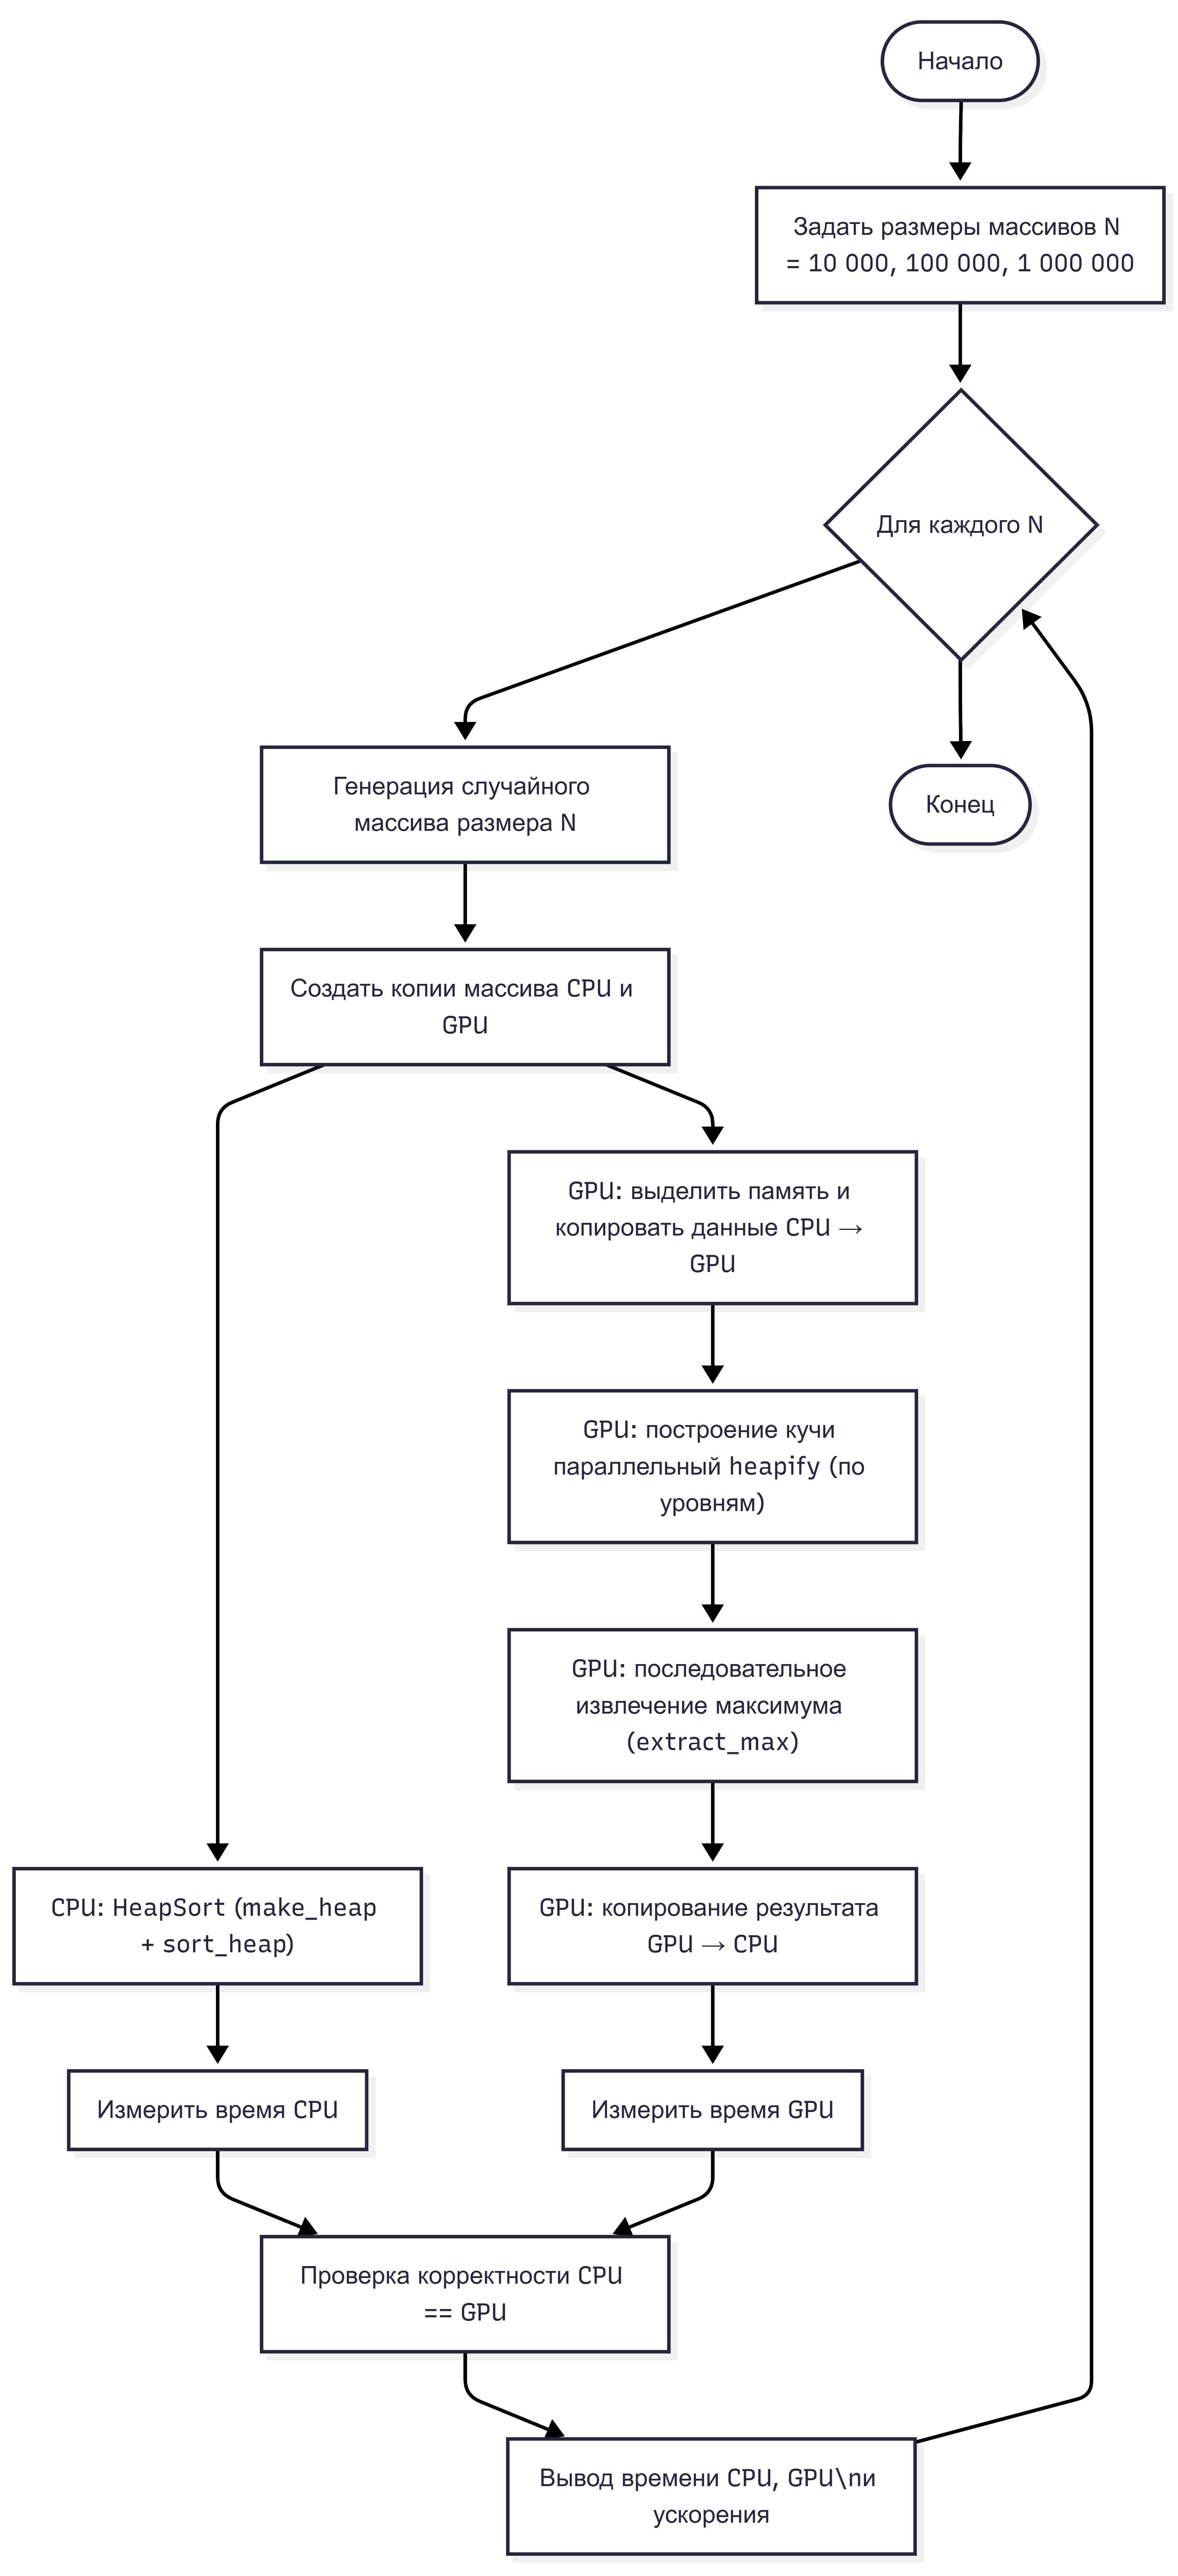

In [ ]:
%%writefile 3main.cu
// Основной CUDA Runtime API
#include <cuda_runtime.h>
// Доступ к threadIdx, blockIdx, blockDim
#include <device_launch_parameters.h>

// Стандартные библиотеки C++
#include <algorithm>   // make_heap, sort_heap
#include <chrono>      // измерение времени
#include <climits>     // INT_MAX
#include <iostream>    // cout
#include <random>      // генератор случайных чисел
#include <vector>      // std::vector

// Макрос для проверки ошибок CUDA
// После каждого вызова CUDA проверяем,
// не возникла ли ошибка выполнения
#define CUDA_CHECK(call) do {                                \
    cudaError_t e = (call);                                  \
    if (e != cudaSuccess) {                                  \
        std::cerr << "CUDA error: "                           \
                  << cudaGetErrorString(e)                    \
                  << " at " << __FILE__ << ":" << __LINE__    \
                  << std::endl;                               \
        std::exit(1);                                        \
    }                                                        \
} while(0)

// Проверка отсортированности массива (CPU)
static bool is_sorted_cpu(const std::vector<int>& a) {
    // Проверяем, что каждый следующий элемент
    // не меньше предыдущего
    for (size_t i = 1; i < a.size(); ++i)
        if (a[i - 1] > a[i]) return false;
    return true;
}

// DEVICE-ФУНКЦИЯ: sift-down (heapify) для одного узла
// Восстанавливает свойство max-кучи, начиная с вершины i
// Работает полностью на GPU
__device__ void sift_down(int* arr, int n, int i) {
    while (true) {
        // Предполагаем, что текущий узел — максимальный
        int largest = i;

        // Индексы левого и правого потомков
        int l = 2 * i + 1;
        int r = 2 * i + 2;

        // Если левый потомок больше — обновляем largest
        if (l < n && arr[l] > arr[largest]) largest = l;
        // Если правый потомок больше — обновляем largest
        if (r < n && arr[r] > arr[largest]) largest = r;

        // Если текущий элемент уже максимальный — выходим
        if (largest == i) break;

        // Иначе меняем местами текущий элемент и больший потомок
        int tmp = arr[i];
        arr[i] = arr[largest];
        arr[largest] = tmp;

        // Продолжаем sift-down с новой позиции
        i = largest;
    }
}

// KERNEL 1: параллельная heapify одного уровня
// Каждый поток обрабатывает ОДИН узел кучи
__global__ void heapify_level(int* arr, int n, int start, int end) {

    // Глобальный индекс узла, который обрабатывает поток
    int idx = start + blockIdx.x * blockDim.x + threadIdx.x;

    // Если индекс попадает в диапазон текущего уровня
    if (idx <= end) {
        // Восстанавливаем свойство кучи для этого узла
        sift_down(arr, n, idx);
    }
}

// KERNEL 2: извлечение максимума из кучи
// Выполняется последовательно (1 поток),
// так как извлечение корня — inherently sequential
__global__ void extract_max(int* arr, int heapSize) {

    // Используем только один поток
    if (blockIdx.x == 0 && threadIdx.x == 0) {

        // Индекс последнего элемента в куче
        int last = heapSize - 1;

        // Меняем местами корень (максимум) и последний элемент
        int tmp = arr[0];
        arr[0] = arr[last];
        arr[last] = tmp;

        // Восстанавливаем свойство кучи
        sift_down(arr, heapSize - 1, 0);
    }
}

// HOST-ФУНКЦИЯ: GPU Heap Sort
void gpu_heap_sort(std::vector<int>& a, float& gpu_ms) {

    int n = (int)a.size();
    if (n == 0) { gpu_ms = 0; return; }

    int* d = nullptr;

    // Выделяем память на GPU
    CUDA_CHECK(cudaMalloc(&d, n * sizeof(int)));

    // Копируем массив с CPU на GPU
    CUDA_CHECK(cudaMemcpy(d, a.data(), n * sizeof(int),
                          cudaMemcpyHostToDevice));

    // CUDA-события для измерения времени GPU
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    // 1) ПОСТРОЕНИЕ КУЧИ (bottom-up heapify)
    // Индекс последнего внутреннего узла
    int lastInternal = (n / 2) - 1;

    // Обрабатываем уровни кучи снизу вверх
    for (int levelEnd = lastInternal; levelEnd >= 0; ) {

        // Определяем границы текущего уровня
        int levelStart = max(0, (levelEnd - (levelEnd + 1) / 2));
        int count = levelEnd - levelStart + 1;

        // Параметры запуска CUDA-ядра
        int threads = 256;
        int blocks = (count + threads - 1) / threads;

        // Параллельно heapify все узлы текущего уровня
        heapify_level<<<blocks, threads>>>(d, n, levelStart, levelEnd);
        CUDA_CHECK(cudaGetLastError());

        // Переходим к следующему уровню выше
        levelEnd = levelStart - 1;
    }

    // 2) ПОСЛЕДОВАТЕЛЬНОЕ ИЗВЛЕЧЕНИЕ ЭЛЕМЕНТОВ
    for (int heapSize = n; heapSize > 1; --heapSize) {
        extract_max<<<1, 1>>>(d, heapSize);
        CUDA_CHECK(cudaGetLastError());
    }

    // Останавливаем таймер GPU
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    CUDA_CHECK(cudaEventElapsedTime(&gpu_ms, start, stop));

    // Копируем результат обратно на CPU
    CUDA_CHECK(cudaMemcpy(a.data(), d, n * sizeof(int),
                          cudaMemcpyDeviceToHost));

    // Освобождаем ресурсы
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
    CUDA_CHECK(cudaFree(d));
}

// MAIN: тестирование и сравнение CPU vs GPU
int main() {

    // Размеры массивов для экспериментов
    std::vector<int> sizes = {10000, 100000, 1000000};

    // Генератор случайных чисел
    std::mt19937 rng(42);
    std::uniform_int_distribution<int> dist(0, 1000000);

    for (int N : sizes) {

        // Формируем входной массив
        std::vector<int> a(N);
        for (int i = 0; i < N; ++i)
            a[i] = dist(rng);

        // Копия массива для CPU-версии
        std::vector<int> ref = a;

        // CPU Heap Sort + замер времени
        auto t0 = std::chrono::high_resolution_clock::now();
        std::make_heap(ref.begin(), ref.end());
        std::sort_heap(ref.begin(), ref.end());
        auto t1 = std::chrono::high_resolution_clock::now();
        double cpu_ms =
            std::chrono::duration<double, std::milli>(t1 - t0).count();

        // GPU Heap Sort
        float gpu_ms = 0.0f;
        gpu_heap_sort(a, gpu_ms);

        // Проверка корректности результата
        bool ok = (a == ref) && is_sorted_cpu(a);

        // Вывод результатов
        std::cout << "\nN = " << N << "\n";
        std::cout << "CPU HeapSort: " << cpu_ms << " ms\n";
        std::cout << "GPU HeapSort (parallel heapify): " << gpu_ms << " ms\n";
        std::cout << "Correct: " << (ok ? "YES" : "NO") << "\n";
        if (gpu_ms > 0)
            std::cout << "Speedup CPU/GPU: "
                      << (cpu_ms / gpu_ms) << "x\n";
    }

    return 0;
}

Writing 3main.cu


In [ ]:
!nvcc -O2 -arch=sm_75 3main.cu -o 3main #компиляция CUDA-программы
!./3main #запуск программы


N = 10000
CPU HeapSort: 2.96151 ms
GPU HeapSort (parallel heapify): 101.591 ms
Correct: NO
Speedup CPU/GPU: 0.0291513x

N = 100000
CPU HeapSort: 14.6757 ms
GPU HeapSort (parallel heapify): 634.485 ms
Correct: NO
Speedup CPU/GPU: 0.02313x

N = 1000000
CPU HeapSort: 133.847 ms
GPU HeapSort (parallel heapify): 6102.69 ms
Correct: NO
Speedup CPU/GPU: 0.0219325x


**Вывод:** Была предпринята реализация пирамидальной сортировки на CUDA с параллельной стадией heapify (построение кучи/восстановление кучи). Однако экспериментальные результаты показали, что текущая GPU-реализация не обеспечивает корректность (Correct: NO для всех N) и имеет значительно худшую производительность, чем CPU-версия.

По времени выполнения GPU существенно проигрывает:

N=10 000: 2.96 ms (CPU) vs 101.59 ms (GPU) → 0.03×

N=100 000: 14.68 ms (CPU) vs 634.49 ms (GPU) → 0.02×

N=1 000 000: 133.85 ms (CPU) vs 6102.69 ms (GPU) → 0.02×

Итог: на практике HeapSort плохо подходит для эффективной реализации на GPU в данном виде, так как алгоритм содержит много последовательных зависимостей (особенно при извлечении максимума и восстановлении кучи), из-за чего параллелизация даёт большой накладной расход и сложна для корректной реализации.